In [1]:
import numpy as np
import scipy
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt
import h5py
import progressbar

from HelperAndMechanics import *
from scipy.ndimage import gaussian_filter1d


In [ ]:
def euclidean_distance_trajectory(x_arr_test_flattened, x_arr_train_flattened):
    '''calculate the euclidean distance between the test and training data. choses shortest eucledean distance
    shape input 
    x_arr_test_flattened: (Dim_x, number_of_comp, 1,len_t_test)
    x_arr_train_flattened: (Dim_x, number_of_comp, number_of_data_points,len_t_train)
    returns an tuple of indices that gives the index of the corresponding training data and time'''

    

    bar = progressbar.ProgressBar(maxval=x_arr_test_flattened.shape[3], \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    #show the time that is to be expected for the loop



    index_list = []
    for current_index in range(x_arr_test_flattened.shape[3]):
        bar.update(current_index)

        # Calculate the euclidean distance between the current test data and all training data
        x_current = x_arr_test_flattened[:,:,0,current_index]
        x_current_broadcasted = x_current.reshape(x_current.shape[0], x_current.shape[1], 1, 1) 
        squared_differences = (x_arr_train_flattened - x_current_broadcasted) ** 2
        sum_squared_differences = np.sum(squared_differences, axis=0)   
        sum_squared_differences = np.sum(sum_squared_differences, axis=0)   
        euclidean_distances = np.sqrt(np.squeeze(sum_squared_differences))  

        # Find the overall minimum distance and its index in the time series
        overall_min_distance = np.min(euclidean_distances)          
        overall_min_flat_index = np.argmin(euclidean_distances)   
        index = np.unravel_index(overall_min_flat_index,euclidean_distances.shape)
        
        index_list.append(index)

    
    return index_list

def shape_data(x_temp,x_cm_temp,dA,y_train_raw,x_arr_test_raw,i,j,number_of_comp,number_of_points,delta_t):
    '''takes in the raw data and shapes it into the correct format for euclidean_distance_trajectory
    shape input
    x_arr_train_flattened_raw: (Dim_x, 1,1, len_t_train)
    x_arr_test_flattened_raw: (Dim_x, 1,1, len_t_test)'''
    key = "dA"
    if key == "x":
        x_arr_train_raw = np.array([x_temp[:,:,i,j],x_temp[:,:,i,j+1],x_temp[:,:,i+1,j+1],x_temp[:,:,i+1,j]])
        x_arr_train = np.swapaxes(x_arr_train_raw,1,2)
        x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1 ,1, -1)       

        #x_arr_test_raw = np.array([x_temp[t_start_test:t_stop_test,:,i,j],x_temp[t_start_test:t_stop_test,:,i,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j]])
        x_arr_test = np.swapaxes(x_arr_test_raw,1,2)
        x_arr_test_flattened_raw = x_arr_test.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1, 1, -1)          
        x_arr_test_flattened = x_arr_test_flattened_raw

        y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)

        for i_y in range(number_of_points):
            for i_x in range(number_of_points):
                i = 5 + i_y * 10
                j = 5 + i_x * 10
                x_arr_train_temp = np.swapaxes(np.array([x_temp[:,:,i,j],x_temp[:,:,i,j+1],x_temp[:,:,i+1,j+1],x_temp[:,:,i+1,j]]),1,2)
                x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1 ,1, -1)    
                x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
                y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)

    if key == "dA":
        x_arr_train = np.array([dA[:,i,j]])
        x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0], 1 ,1, -1)       

        x_arr_test_flattened_raw = x_arr_test_raw.reshape(x_arr_train.shape[0 ], 1, 1, -1)          
        x_arr_test_flattened = x_arr_test_flattened_raw
        y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)

        for i_y in range(number_of_points):
            for i_x in range(number_of_points):
                i = 5 + i_y * 10
                j = 5 + i_x * 10
                x_arr_train_temp = np.array([dA[:,i,j]])
                x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0], 1 ,1, -1)    
                x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
                y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)
        
    x_arr_train_flattened = x_arr_train_flattened_raw
    x_arr_test_flattened = x_arr_test_flattened_raw

    #concentate different time shifts of the data
    for shift in range(-int(number_of_comp/2),int(number_of_comp/2)+1):
        if shift == 0:
            continue
        else:
            x_arr_train_flattened_shifted = np.roll(x_arr_train_flattened_raw,shift * delta_t, axis=3)
            x_arr_test_flattened_shifted = np.roll(x_arr_test_flattened_raw,shift * delta_t, axis=3)
            x_arr_train_flattened = np.concatenate((x_arr_train_flattened,x_arr_train_flattened_shifted),axis=1)
            x_arr_test_flattened = np.concatenate((x_arr_test_flattened,x_arr_test_flattened_shifted),axis=1)

    return x_arr_train_flattened, x_arr_test_flattened,np.swapaxes((y_train),0,1)

In [3]:
N = 9000
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta05l.h5', 'r') as f:
    x_temp = f['x_temp'][:]
    x_cm_temp = f['x_cm_temp'][:]
    T = f['T'][:]
    dA = f['dA'][:]
    f.close()
#normalize each point
x_temp = x_temp-x_cm_temp[0,:,:,:]

In [4]:
#T = u
t_start,t_stop = 0,7000
i,j = 80,40

T_train = T[t_start:t_stop,i,j]

dA_test = dA[t_stop+500:,i,j]
T_test = T[t_stop+500:,i,j]
#x_arr_train_raw = np.array([x_temp[t_start:t_stop,:,i,j],x_temp[t_start:t_stop,:,i,j+1],x_temp[t_start:t_stop,:,i+1,j+1],x_temp[t_start:t_stop,:,i+1,j]])
x_arr_test_raw = np.array([x_temp[t_stop+500:,:,i,j],x_temp[t_stop+500:,:,i,j+1],x_temp[t_stop+500:,:,i+1,j+1],x_temp[t_stop+500:,:,i+1,j]])
dA_test_raw = dA[t_stop+500:,i,j]

[153 682]
7553 8766


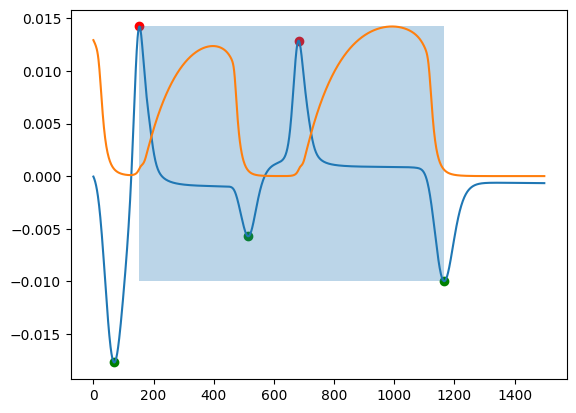

In [5]:
maxima_temp0, _ = find_peaks(dA_test,prominence=.0007)#,height=.001
minima_temp0, _ = find_peaks(-dA_test,prominence=.0007)#,height=.001
print(maxima_temp0)
max_indx, min_indx = index_finder(maxima_temp0, minima_temp0, dA_test,start_indx=0)

plt.plot(dA_test)
plt.scatter(maxima_temp0,dA_test[maxima_temp0],c='r')
plt.scatter(minima_temp0,dA_test[minima_temp0],c='g')
plt.fill_between([maxima_temp0[max_indx],minima_temp0[min_indx+1]],dA_test[minima_temp0[min_indx+1]],dA_test[maxima_temp0[max_indx]],alpha=.3)
plt.plot(T_test/np.max(T_test)*np.max(dA_test))

t_start_test = t_stop + 500 + maxima_temp0[max_indx] - 100
t_stop_test = t_stop + 500+ minima_temp0[min_indx+1] + 100

print(t_start_test,t_stop_test)

In [6]:
np.array([dA[:,i,j]]).shape[0]

1

In [7]:
T_test_raw = T[t_start_test:t_stop_test,i,j]
x_arr_test_raw = np.array([x_temp[t_start_test:t_stop_test,:,i,j],x_temp[t_start_test:t_stop_test,:,i,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j]])
dA_test_raw = dA[t_start_test:t_stop_test,i,j]

number_of_comp,number_of_points,delta_t = 15,10,10 
# x_arr_train_flattened, x_arr_test_flattened,y_train = shape_data(x_temp[t_start:t_stop,:,:,:],x_cm_temp[t_start:t_stop,:,:,:],dA[t_start:t_stop,i,j],T[t_start:t_stop,:,:],x_arr_test_raw,i,j,number_of_comp,number_of_points,delta_t)
#print(x_arr_train_flattened.shape,x_arr_test_flattened.shape)
x_train,x_test, y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_test_raw,i,j,number_of_comp,number_of_points,delta_t)

index_list = euclidean_distance_trajectory(x_test, x_train)

In [8]:
y_out = [y_train[row][col] for row, col in index_list]
#y_out = [y_train[0][row[0]] for row in index_list]
y_control = [y_train[0][row[0]] for row in index_list]

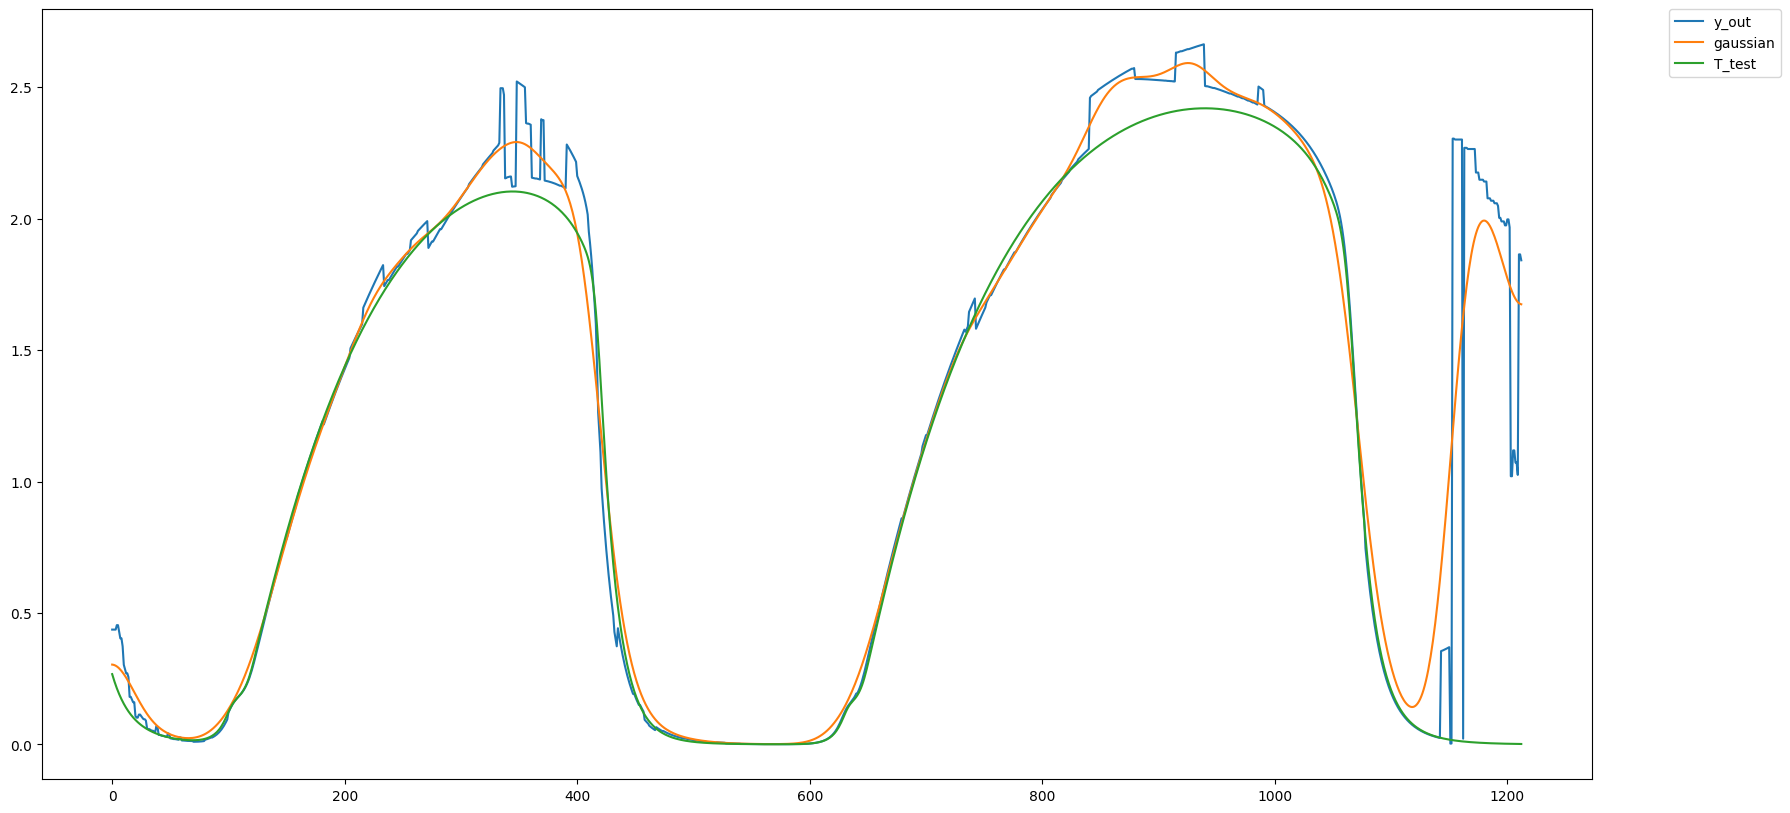

In [9]:
T_train_smoothed = gaussian_filter1d(y_out, sigma=15)
#apple laplacian smoothing to y_out
#aplly np.convolve with laplacian kernel to y_out
T_train_convolved = convolve1d(y_out, [1,-2,1], mode='nearest')
T_train_convolved = y_out - .5 * T_train_convolved


def low_pass_filter(time_series, cutoff_freq):
    freq = np.fft.rfftfreq(len(time_series))
    fft_series = np.fft.rfft(time_series)
    fft_series[freq > cutoff_freq] = 0  # Remove high frequencies
    return np.fft.irfft(fft_series)

# Apply low-pass filtering
T_train_lowpass = low_pass_filter(y_out, cutoff_freq=0.05)


plt.figure(figsize=(20,10))
plt.plot(y_out,label='y_out')
# plt.plot(T_train_lowpass,label='lowpass')
plt.plot(T_train_smoothed,label='gaussian')
plt.plot(T_test_raw,label='T_test')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('test.png')

In [10]:
import numpy as np
from scipy.ndimage import convolve1d

# Example time series
time_series = np.array([1, 2, 3, 10, 3, 2, 1])

# Define a Laplacian smoothing kernel (symmetric averaging kernel)
kernel = np.array([0.25, 0.5, 0.25])

# Apply smoothing using convolve1d from scipy
smoothed_time_series = convolve1d(time_series, kernel, mode='nearest')

# Results
print("Original Time Series:", time_series)
print("Smoothed Time Series:", smoothed_time_series)


Original Time Series: [ 1  2  3 10  3  2  1]
Smoothed Time Series: [1 2 4 6 4 2 1]


In [11]:
T_test_raw = T[t_start_test:t_stop_test,i,j]
x_arr_test_raw = np.array([x_temp[t_start_test:t_stop_test,:,i,j],x_temp[t_start_test:t_stop_test,:,i,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j]])

delta_t = 15
number_of_comp = 3
x_arr_train = np.swapaxes(x_arr_train_raw,1,2)
x_arr_train_flattened_raw = x_arr_train.reshape(8, 1, -1)             
x_arr_train_flattened = x_arr_train_flattened_raw

x_arr_test = np.swapaxes(x_arr_test_raw,1,2)
x_arr_test_flattened_raw = x_arr_test.reshape(8, 1, -1)          
x_arr_test_flattened = x_arr_test_flattened_raw


NameError: name 'x_arr_train_raw' is not defined

In [ ]:
for shift in range(-int(number_of_comp/2),int(number_of_comp/2)+1):
    if shift == 0:
        continue
    else:
        x_arr_train_flattened_shifted = np.roll(x_arr_train_flattened_raw,shift * delta_t, axis=2)
        x_arr_test_flattened_shifted = np.roll(x_arr_test_flattened_raw,shift * delta_t, axis=2)
        #add to X_arr_train_flattened along axis 1
        x_arr_train_flattened = np.concatenate((x_arr_train_flattened,x_arr_train_flattened_shifted),axis=1)
        x_arr_test_flattened = np.concatenate((x_arr_test_flattened,x_arr_test_flattened_shifted),axis=1)

time_indices = []


#x_arr_train_flattened,x_arr_test_flattened = shape_data(x_arr_train_raw,x_arr_test_raw,0,delta_t,number_of_comp) 

for current_index in range(delta_t*number_of_comp,x_arr_test_flattened.shape[-1]-delta_t*number_of_comp):
    x_current = x_arr_test_flattened[:,:,current_index]
    x_current_broadcasted = x_current.reshape(x_current.shape[0], x_current.shape[1], 1) 
    squared_differences = (x_arr_train_flattened - x_current_broadcasted) ** 2
    #print(squared_differences.shape)
    sum_squared_differences = np.sum(squared_differences, axis=0)   # Shape: (1, len_t)
    #print(sum_squared_differences.shape)
    sum_squared_differences = np.sum(sum_squared_differences, axis=0)   # Shape: (1, len_t)
    #print(sum_squared_differences.shape)
    euclidean_distances = np.sqrt(np.squeeze(sum_squared_differences))  # Shape: (len_t,)#print('shape (len_t,)',euclidean_distances.shape)
    #print(euclidean_distances.shape)
    # Find the overall minimum distance and its index in the time series
    overall_min_distance = np.min(euclidean_distances)              # Minimum Euclidean distance
    overall_min_flat_index = np.argmin(euclidean_distances)              # Time index where minimum occurs
    
    time_indices.append(overall_min_flat_index)
    

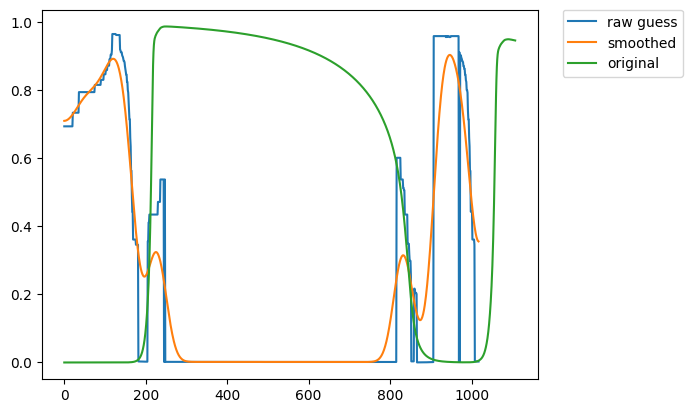

In [ ]:
#apply gaussian smoothing to T_train
from scipy.ndimage import gaussian_filter1d

T_train_smoothed = gaussian_filter1d(T_train[time_indices], sigma=20)

plt.plot(T_train[time_indices], label='raw guess')
plt.plot(T_train_smoothed, label='smoothed')
plt.plot(T_test_raw, label='original')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)